In [1]:
# install
# pip install novosparc

In [2]:
# imports
import os
import numpy as np
import pandas as pd
import scanpy as sc
import novosparc
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, squareform, pdist

# Reconstructing the Drosophila embryo

This tutorial uses `novoSpaRc` to reconstruct single-cell gene expression of the Drosophila scRNA-seq dataset [Karaiskos et al., 2017, Science](https://science.sciencemag.org/content/358/6360/194). 

We differentiate between three modes of `novoSpaRc` reconstruction: 
1. Using only markers for reconstruction (using [Berkeley drosophila transcription network project ](http://bdtnp.lbl.gov/Fly-Net/bioimaging.jsp)) $\rightarrow \alpha_{linear} = 1$
2. De novo, relying on cell-cell distances, and location-location distances similarity (no prior information) $\rightarrow \alpha_{linear} = 0$
2. Integrating both assumptions  $\rightarrow 0 < \alpha_{linear} < 1$

In [3]:
# data
data_dir = 'novosparc/datasets/drosophila_scRNAseq/'
atlas_dir = 'novosparc/datasets/bdtnp/'
output_folder = None #''
with_atlas = True

In [4]:
# genes and cells to plot
pl_genes = ['sna', 'ken', 'eve']
pl_cells = [58, 23, 200]

## Prepare Inputs

### Cell Expression

Preparing cells expression consists of:
1. Reading the data
2. Preprocessing
3. (optional) If using the structural correspondence assumption ($\alpha_{linear} < 1$), it is advisable to generate a lower representation of expression for the cells.

In [5]:
# Reading expression data to scanpy AnnData (cells x genes)
data_path = os.path.join(data_dir, 'dge_normalized.txt')
dataset = pd.read_csv(data_path, index_col=0, sep='\t').T
dataset = sc.AnnData(dataset)
gene_names = dataset.to_df().columns

ncells, ngenes = dataset.shape
print('number of cells: %d' % ncells)
print('number of genes: %d' % ngenes)

number of cells: 1297
number of genes: 8924


In [6]:
# preprocess
sc.pp.normalize_per_cell(dataset)
sc.pp.log1p(dataset)

/usr/local/opt/pyenv/versions/3.7.5/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [7]:
# optional: subset cells
ncells = 500
sc.pp.subsample(dataset, n_obs=ncells)

/usr/local/opt/pyenv/versions/3.7.5/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [8]:
# optional: generating a lower representation of expression
# in order to improve cell-cell and location-location distances correspondence

dge_rep = None # a representation of cells gene expression
sc.pp.highly_variable_genes(dataset)
is_var_gene = dataset.var['highly_variable']
var_genes = list(is_var_gene.index[is_var_gene])


# alternative 1:
dge_rep = dataset.to_df()[var_genes]

# # alternative 2:
# sc.pp.pca(dataset)
# dge_rep = pd.DataFrame(dataset.obsm['X_pca'])


### Construct Target Atlas

1. When using expression of marker genes ($\alpha_{linear} > 0$), target space has to correspond to the atlas' locations.

**Otherwise, there are two alternatives:**

2. Prior shape without exact locations
3. No prior knowledge of target space

In [9]:
# create target space (locations x dims)

# alternative 1 (must if using atlas!): Target space available apriori
if with_atlas:
    num_locations = 3039
    target_space_path = os.path.join(atlas_dir, 'geometry.txt')
    locations = pd.read_csv(target_space_path, sep=' ')
    locations = locations[:num_locations][['xcoord', 'zcoord']].values
else:
#     # alternative 2: Prior shape without exact locations
#     tissue_path = 'novosparc/datasets/tissue_example.png'
#     locations = novosparc.geometry.create_target_space_from_image(tissue_path)

    # alternative 3: No prior knowledge of target space
    locations = novosparc.geometry.construct_circle(num_locations=num_locations)
    
    # optional: subsample locations
    num_locations = 3039
    if locations.shape[0] > num_locations:
        idx_locs = np.random.choice(locations.shape[0], num_locations, replace=False)
        locations = locations[idx_locs, :]

print('Num locations: %d' % locations.shape[0])

Num locations: 3039


Text(0.5, 1.0, 'Target Space')

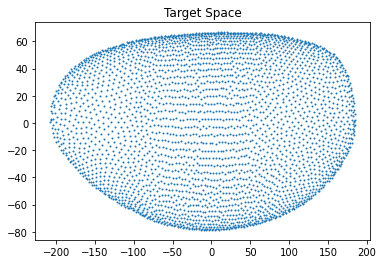

In [10]:
# view target space
%matplotlib inline
plt.scatter(locations[:, 0], locations[:, 1], s=1)
plt.title('Target Space')

### Optional: Atlas Expression

We read here a reference expression of marker genes over locations. 

Having access to partial expression of genes over the tissue we can also test visualize the structural assumption and inquire how "spatially informative" are the given marker genes. 

In [11]:
# reading reference atlas
if with_atlas:
    atlas_path = os.path.join(atlas_dir, 'dge.txt')
    atlas = pd.read_csv(atlas_path, sep='\t')

/usr/local/opt/pyenv/versions/3.7.5/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


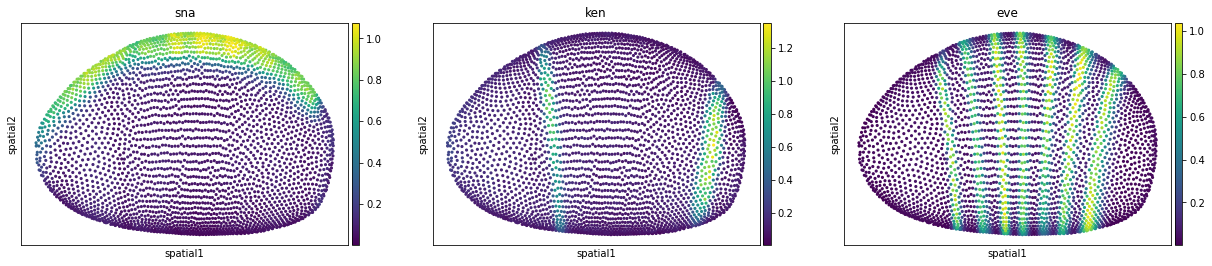

In [12]:
# view a gene's expression
if with_atlas:
    dataset_atlas = sc.AnnData(atlas)
    dataset_atlas.obsm['spatial'] = locations
    sc.pl.embedding(dataset_atlas, basis="spatial", color=pl_genes)

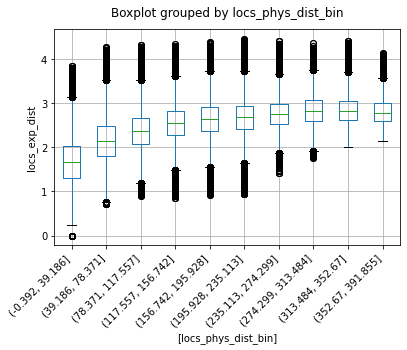

In [13]:
# Tip: if an atlas is provided, then one can test to what extent the structural correspondence assuption holds.
# A proxy is to look at the loc-loc expression distances vs their physical distances, hoping to see an upward-going trend. 
if with_atlas:
    locs_exp_dist = squareform(pdist(atlas.values))
    locs_phys_dist = squareform(pdist(locations))
    df = pd.DataFrame({'locs_exp_dist': locs_exp_dist.flatten(), 
                  'locs_phys_dist': locs_phys_dist.flatten()})

    nbins = 10
    df['locs_phys_dist_bin'] = pd.cut(df['locs_phys_dist'], bins=nbins)
    df.boxplot(column=['locs_exp_dist'], by=['locs_phys_dist_bin'])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('locs_exp_dist')
    plt.title('')

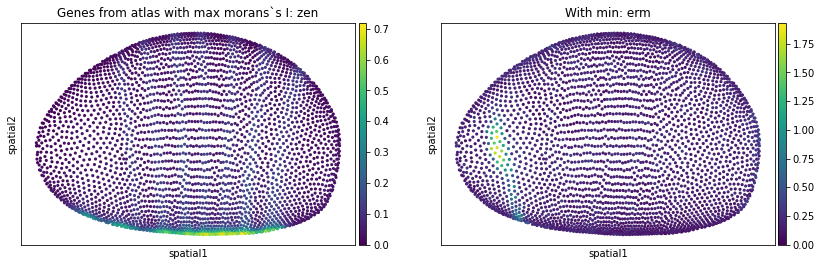

In [14]:
# Tip: one can test how "spatially informative" are the marker genes. 
# one measure indicating how localized is the expression is Moran's I

if with_atlas:
    mI, pvals = novosparc.analysis._analysis.get_moran_pvals(locations, X=atlas, n_neighbors=10)

    df = pd.DataFrame({'moransI': mI, 'pval': pvals}, index=atlas.columns)
    gene_max_mI = df['moransI'].idxmax()
    gene_min_mI = df['moransI'].idxmin()
    tits = ['Genes from atlas with max morans`s I: %s' % gene_max_mI, 'With min: %s' % gene_min_mI]
    sc.pl.embedding(dataset_atlas, basis="spatial", color=[gene_max_mI, gene_min_mI], title=tits)

## OT Reconstruction

For `novoSpaRc` OT reconstruction, we:
1. Construct a Tissue object.
2. Compute relevant cost matrices.
    - simultaniously, smooth and linear costs
    - handling assumptions individually
3. Computing Optimal Transport of cells to locations

In [15]:
# construct tissue object
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations)

In [16]:
# compute cost matrices
# params for smooth cost
num_neighbors = 5

# params for linear cost
if with_atlas:
    markers = list(set(atlas.columns).intersection(gene_names))
    atlas_matrix = atlas[markers].values
    markers_idx = pd.DataFrame({'markers_idx': np.arange(ngenes)}, index=gene_names)
    markers_to_use = np.concatenate(markers_idx.loc[markers].values)

# # alternative 1: setup both assumptions 
# if with_atlas:
#     tissue.setup_reconstruction(atlas_matrix=atlas_matrix, markers_to_use=markers_to_use, 
#                             num_neighbors_s=num_neighbors, num_neighbors_t=num_neighbors)
# else:
#     tissue.setup_reconstruction(num_neighbors_s=num_neighbors, num_neighbors_t=num_neighbors)

# alternative 2: handling each assumption separately
tissue.setup_smooth_costs(dge_rep=dge_rep)
if with_atlas:
    tissue.setup_linear_cost(markers_to_use, atlas_matrix)

Setting up for reconstruction ... done ( 3.91 seconds )


In [17]:
# compute optimal transport of cells to locations
alpha_linear = 0.5 if with_atlas else 0
tissue.reconstruct(alpha_linear=alpha_linear)

Reconstructing spatial information with 84 markers: 500 cells and 3039 locations ... 
Trying with epsilon: 5.00e-04


/usr/local/opt/pyenv/versions/3.7.5/lib/python3.7/site-packages/ot/bregman.py:364: RuntimeWarning: divide by zero encountered in true_divide
  u = 1. / np.dot(Kp, v)


Trying with epsilon: 5.00e-03
Trying with epsilon: 5.00e-02
It.  |Err         
-------------------
    0|2.096126e-04|
Using epsilon: 0.05000000


## Predicted Expression

Visualizing the results we show:
1. Reconstructed expression of individual genes
2. Probability of individual cells belonging to each location
3. Looking for spatially informative genes according to reconstruction in highly variable genes
4. Plot spatial expression archtypes

/usr/local/opt/pyenv/versions/3.7.5/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


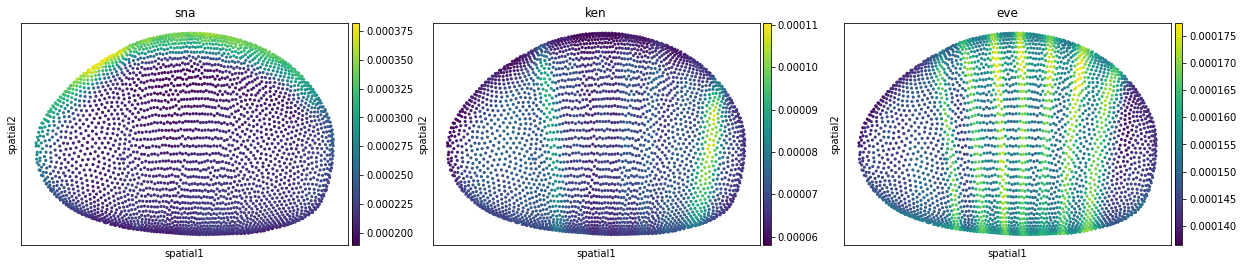

In [18]:
# reconstructed expression of individual genes
sdge = tissue.sdge
dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst.obsm['spatial'] = locations
sc.pl.embedding(dataset_reconst, basis="spatial", color=pl_genes)

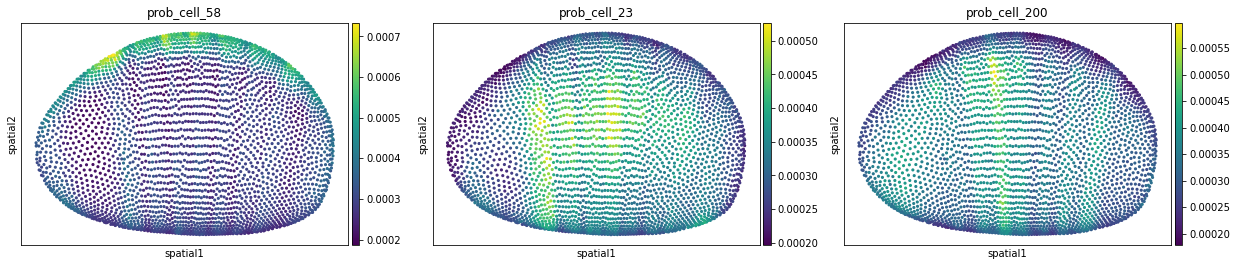

In [19]:
# probability of individual cells belonging to each location
gw = tissue.gw
ngw = (gw.T / gw.sum(1)).T
cell_idx = np.arange(ncells)
dataset_reconst.obs = pd.DataFrame(ngw.T, columns=['prob_cell_%d' % i for i in cell_idx])

sc.pl.embedding(dataset_reconst, basis="spatial", color=['prob_cell_%d' % i for i in pl_cells]) 

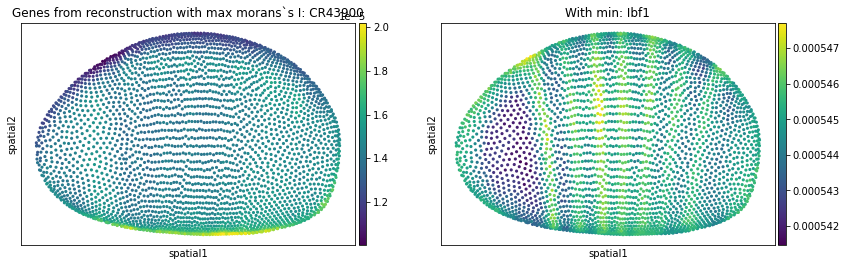

In [20]:
# Looking for spatially informative genes according to reconstruction in highly variable genes
X = dataset_reconst.to_df()[var_genes]
mI, pvals = novosparc.analysis._analysis.get_moran_pvals(locations, X=X, n_neighbors=10)

df = pd.DataFrame({'moransI': mI, 'pval': pvals}, index=var_genes)
gene_max_mI = df['moransI'].idxmax()
gene_min_mI = df['moransI'].idxmin()
tits = ['Genes from reconstruction with max morans`s I: %s' % gene_max_mI, 'With min: %s' % gene_min_mI]
sc.pl.embedding(dataset_reconst, basis="spatial", color=[gene_max_mI, gene_min_mI], title=tits)

Finding gene archetypes ... 

/usr/local/opt/pyenv/versions/3.7.5/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


done


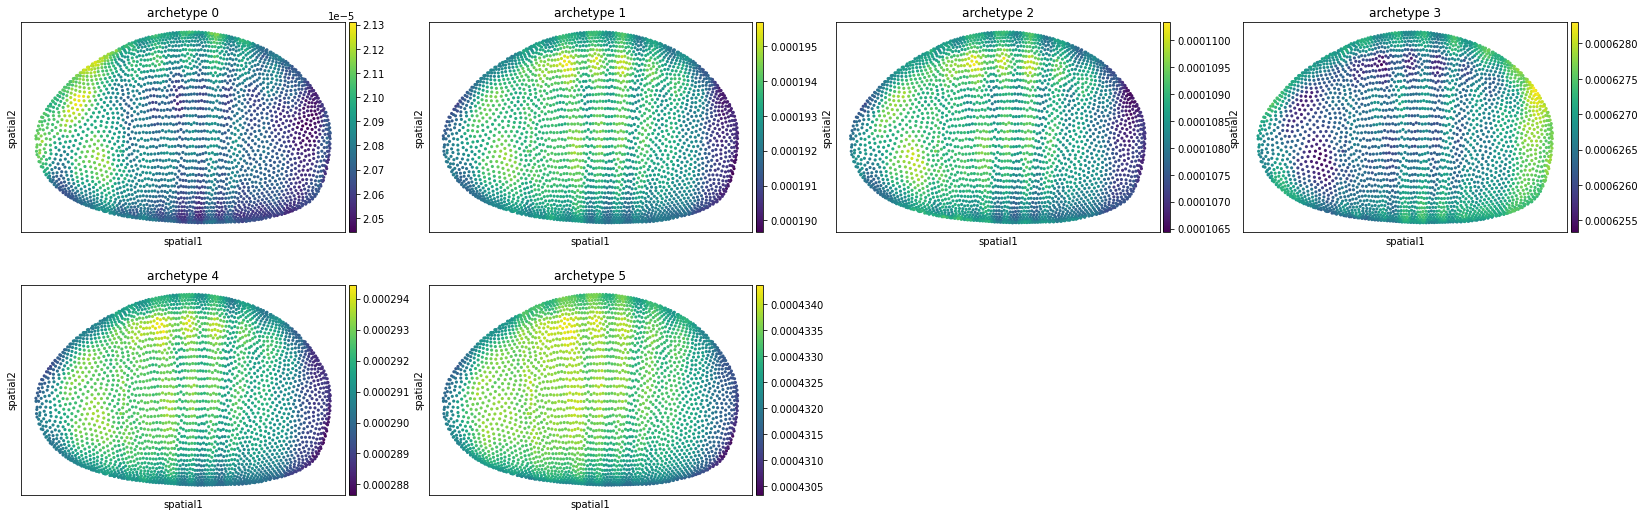

In [21]:
# plot spatial expression archtypes
num_clusters = 6
archetypes, clusters, gene_corrs = novosparc.rc.find_spatial_archetypes(num_clusters, sdge)

arch_cols = ['archetype %d'% i for i in np.arange(num_clusters)]
df = pd.DataFrame(archetypes.T, columns=arch_cols)
dataset_reconst.obs = pd.concat((dataset_reconst.obs, df), 1)
sc.pl.embedding(dataset_reconst, basis="spatial", color=arch_cols)